### Screamers: 
It is well known that WRITING IN ALL CAPS ONLINE IS A SUBSTITUTE FOR SCREAMING… OR YELLING. *cough!*. (Or some might say it’s simply cruise control for cooooool). Write a job to find users that scream a lot, and provide a screamer score (a highly-technical metric that you will invent).

For future reference (when we really want to get something off our chest), what are the top 5 subreddits for scream-y comments?

#### Loading sample data into dataframe

In [1]:
# from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import from_json, col
conf = SparkConf().setAppName('FirstSpark2').setMaster('Spark')
sc = SparkContext.getOrCreate()

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
df = sqlContext.read.json("hdfs://orion11:20001/sample_sampled_reddit/")

#### Filtering dataset

In [2]:
df2 = df.filter(
~(df.body.like('[deleted]'))
    & ~(df.body.isNull())
    & ~(df.author.like('[deleted]'))
    & ~(df.author.like('AutoModerator')) 
    & ~(df.author.rlike("[bB][oO][tT]"))

)

print(type(df2))
print(df2.count())
df2.show(1)

<class 'pyspark.sql.dataframe.DataFrame'>
27303462
+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+--------------+-------+------------+-----+-----+------------+--------+---------------+------------+---+------------+
|archived|        author|author_cakeday|author_flair_css_class|author_flair_text|                body|body_html|controversiality|created|created_utc|distinguished|downs|edited|gilded|     id|  link_id|mod_reports|name|parent_id|removal_reason|replies|retrieved_on|saved|score|score_hidden|stickied|      subreddit|subreddit_id|ups|user_reports|
+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+--------------+-------+--------

#### Creating a view

In [3]:
%%time
df2.createOrReplaceTempView("dataframe")

CPU times: user 1.66 ms, sys: 94 µs, total: 1.75 ms
Wall time: 108 ms


#### Using the view

In [4]:
%%time
df3 = spark.sql('SELECT * FROM dataframe')
df3.show(3)

+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+----------+--------------+-------+------------+-----+-----+------------+--------+---------------+------------+---+------------+
|archived|        author|author_cakeday|author_flair_css_class|author_flair_text|                body|body_html|controversiality|created|created_utc|distinguished|downs|edited|gilded|     id|  link_id|mod_reports|name| parent_id|removal_reason|replies|retrieved_on|saved|score|score_hidden|stickied|      subreddit|subreddit_id|ups|user_reports|
+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+----------+--------------+-------+------------+-----+-----+------------+--------+---------

#### Adding a column "scream_score" which gives the count of words that have atleast two CAPS ALphabets in words in the body   

In [5]:
%%time
from pyspark.sql import functions as F
import re
from pyspark.sql.functions import udf
from pyspark.sql.types import *

pattern = "\b[A-Z]+"

def getScore(body):
    list = re.findall(pattern, body)
    print(len(list))
    return len(list)

Score = udf(getScore, StringType())
df4 = df3.withColumn('scream_score', Score("body"))

print(type(df4))
print(df4.count())
df4.show(1)

<class 'pyspark.sql.dataframe.DataFrame'>
27303462
+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+--------------+-------+------------+-----+-----+------------+--------+---------------+------------+---+------------+------------+
|archived|        author|author_cakeday|author_flair_css_class|author_flair_text|                body|body_html|controversiality|created|created_utc|distinguished|downs|edited|gilded|     id|  link_id|mod_reports|name|parent_id|removal_reason|replies|retrieved_on|saved|score|score_hidden|stickied|      subreddit|subreddit_id|ups|user_reports|scream_score|
+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+-----

#### seeing comments with scream_score > 0

In [6]:
df4.select(df4.id, df4.author, df4.body, df4.scream_score).filter(df4.author.like('bravado')).filter(df4.scream_score>0).show(2, False)



+-------+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|id     |author |body                                                                                                                                                                                                                                                                                                                                                                                                                                            

#### Group by Author to get the top users that scream a lot

In [10]:
groupedByAuthor = df4.groupBy(df4.author)
#groupedByAuthor.agg({'scream_score':'sum'}).orderBy('sum(scream_score)', ascending=False).show()

comp = groupedByAuthor.agg({'scream_score':'sum'}).orderBy('sum(scream_score)', ascending=False)
comp.show()


+-------------------+-----------------+
|             author|sum(scream_score)|
+-------------------+-----------------+
|            bravado|              7.0|
|            tostono|              4.0|
|             daberu|              2.0|
|            brianm1|              1.0|
|    FUCKYOURENGLISH|              1.0|
|           bookey23|              1.0|
|       SpringsHaven|              1.0|
|             frosse|              1.0|
|             Extr22|              1.0|
|            Swegali|              1.0|
|              ecco5|              1.0|
|            dash006|              1.0|
|      riemannszeros|              1.0|
|           sheenobu|              1.0|
|       AsianEyePeas|              1.0|
|             pynzrz|              1.0|
|             Horong|              1.0|
|trevorthecerealbowl|              0.0|
|        Juergenator|              0.0|
|      Sixty-to-Zero|              0.0|
+-------------------+-----------------+
only showing top 20 rows



#### Bar Graph of top 10 screamer authors

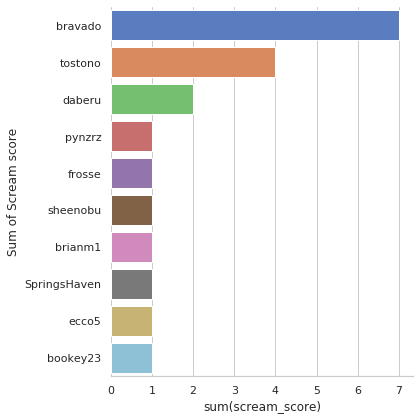

In [16]:
import seaborn as sns

sns.set(style="whitegrid")


comp = comp.limit(10)
comp_P = comp.toPandas()


# Draw a nested barplot to show survival for avg(sentiment) and subreddit
g = sns.catplot(x="sum(scream_score)", y="author", data=comp_P, height=6, kind="bar", palette="muted")

g.despine(left=True)
g.set_ylabels("Sum of Scream score")

#### Group by subreddit to get the subreddits having screaming comments

In [18]:
groupedBySubreddit = df4.groupBy(df4.subreddit)
comp1 = groupedBySubreddit.agg({'scream_score':'sum'}).orderBy('sum(scream_score)', ascending=False)
comp1.show()

+------------------+-----------------+
|         subreddit|sum(scream_score)|
+------------------+-----------------+
|               zen|              4.0|
|             apple|              3.0|
|  A858DE45F56D9BC9|              2.0|
|           whiskey|              2.0|
|        reddit.com|              1.0|
|            gaming|              1.0|
|         Minecraft|              1.0|
|elderscrollsonline|              1.0|
|             Games|              1.0|
|            Korean|              1.0|
|         AskReddit|              1.0|
|        technology|              1.0|
|              pics|              1.0|
|            canada|              1.0|
|             tarot|              1.0|
|            HiTMAN|              1.0|
|        MensRights|              1.0|
|        SteamTrade|              1.0|
|              osgi|              1.0|
|      listentothis|              1.0|
+------------------+-----------------+
only showing top 20 rows



#### Bar graph for top 10 screamer subreddits

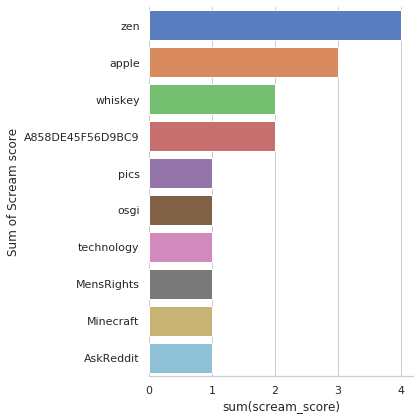

In [19]:
import seaborn as sns

sns.set(style="whitegrid")


comp1 = comp1.limit(10)
comp_P1 = comp1.toPandas()


# Draw a nested barplot to show survival for avg(sentiment) and subreddit
g = sns.catplot(x="sum(scream_score)", y="subreddit", data=comp_P1, height=6, kind="bar", palette="muted")

g.despine(left=True)
g.set_ylabels("Sum of Scream score")